In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from lxml import etree
import numpy as np
import glob
import matplotlib.patches as Rectangle
print(tf.__version__)
tf.test.is_gpu_available()

2.0.0


True

# 读取图片

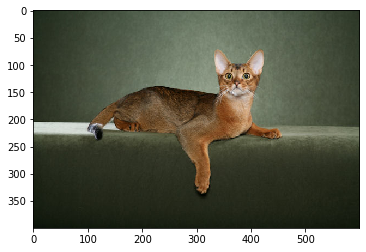

In [5]:
#显示图片
img = tf.io.read_file("./Image_location/images/Abyssinian_1.jpg")
img = tf.image.decode_jpeg(img)
plt.imshow(img)
plt.show()

In [6]:
xml = open("./Image_location/annotations/xmls/Abyssinian_1.xml").read()
sel = etree.HTML(xml)
width = int(sel.xpath("//size/width/text()")[0])
height = int(sel.xpath("//size/height/text()")[0])
xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
ymax = int(sel.xpath("//bndbox/ymax/text()")[0])

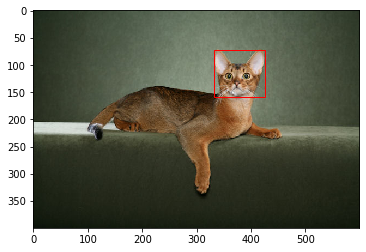

In [7]:
from matplotlib.patches import Rectangle
plt.imshow(img)
#给定左下角坐标
rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color = "red")
ax = plt.gca()
ax.axes.add_patch(rect)

# 规范化
图片大小不一，对应的框也要对应的转换，我们的目标值应该怎么设计，这些数据都是相对图像的高和宽，我们知道所在的比例，就可以找的头部所在的位置，这就是是我们做变换的原因。

In [8]:
img = tf.image.resize(img,[224,224])
xmin = (xmin/width)*224
ymin = (ymin/height)*224
xmax = (xmax/width)*224
ymax = (ymax/height)*224

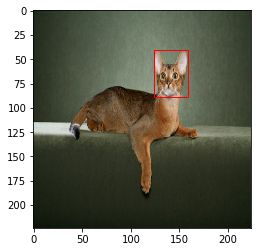

In [9]:
from matplotlib.patches import Rectangle
plt.imshow(img.numpy()/255.0)
#给定左下角坐标
rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color = "red")
ax = plt.gca()
ax.axes.add_patch(rect)

# 数据的预处理
## 创建输入管道

In [10]:
images = glob.glob("./Image_location/images/*.jpg")
xmls = glob.glob("./Image_location/annotations/xmls/*.xml")
#获取文件的名称
names = [x.split("\\")[-1].split(".xml")[0] for x in xmls]
imgs_train = [img for img in images if img.split("\\")[-1].split(".jpg")[0] in names]
imgs_test = [img for img in images if img.split("\\")[-1].split(".jpg")[0] not in names]
#对其进行排序
imgs_train.sort(key=lambda x :x.split("\\")[-1].split(".jpg")[0])
xmls.sort(key=lambda x :x.split("\\")[-1].split(".xml")[0])
#排序后确定类别
names = [x.split("\\")[-1].split(".xml")[0] for x in xmls]
class_label = ["cat","dog"]
class_label_index = dict((name,index) for index,name in enumerate(class_label))
label = [class_label_index[class_label[0]] if label.istitle() else class_label_index[class_label[1]] for label in names]


In [12]:
def to_labels(path):
    xml = open("{}".format(path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath("//size/width/text()")[0])
    height = int(sel.xpath("//size/height/text()")[0])
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    return [xmin/width,ymin/height,xmax/width,ymax/height]



#读取位置信息
labels = [to_labels(path) for path in xmls]

out1,out2,out3,out4 = list(zip(*labels))
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)
label = np.array(label)
label_datasets = tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4,label))

In [16]:
def loda_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,(224,224))
    img = img/127.5 - 1 #规划到-1到1之间
    return img
image_dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_dataset = image_dataset.map(loda_image,num_parallel_calls=AUTOTUNE)
dataset = tf.data.Dataset.zip((image_dataset,label_datasets))
dataset

<ZipDataset shapes: ((224, 224, 3), ((), (), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int32))>

# 设置批次

In [17]:
#%%设置训练数据和验证集数据的大小
test_count = int(len(imgs_train)*0.2)
train_count = len(imgs_train) - test_count
print(test_count,train_count)
#跳过test_count个
dataset = dataset.shuffle(buffer_size=len(imgs_train))
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

batch_size = 16
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = train_dataset.shuffle(buffer_size=train_count).repeat().batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.batch(batch_size)

737 2949


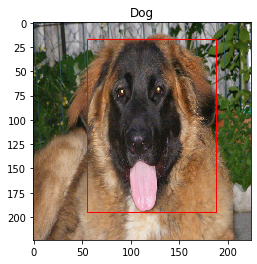

In [18]:
from matplotlib.patches import Rectangle
for img,label in train_ds.take(1):
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    out1,out2,out3,out4,out5= label
    xmin,ymin,xmax,ymax = out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    #给定左下角坐标
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color = "red")
    ax = plt.gca()
    ax.axes.add_patch(rect)
    plt.title((class_label[out5[0]]).title())
    plt.show()

# 创建模型

In [20]:
xcpetion = tf.keras.applications.Xception(input_shape=(224, 224, 3), 
                                               include_top=False,
                                               weights='imagenet')

inputs = tf.keras.layers.Input(shape=(224,224,3))
x = xcpetion(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x1 = tf.keras.layers.Dense(2048, activation='relu')(x)

x1 = tf.keras.layers.Dense(256, activation='relu')(x1)
out1 = tf.keras.layers.Dense(1,name="out1")(x1)
out2 = tf.keras.layers.Dense(1,name="out2")(x1)
out3 = tf.keras.layers.Dense(1,name="out3")(x1)
out4 = tf.keras.layers.Dense(1,name="out4")(x1)

x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
out_class = tf.keras.layers.Dense(1,activation='sigmoid',name='out_item')(x2)



prediction = [out1,out2,out3,out4,out_class]
model = tf.keras.models.Model(inputs=inputs,outputs=prediction)
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 7, 7, 2048)   20861480    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         4196352     global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'out1':'mse',
                    'out2':'mse',
                    'out3':'mse',
                    'out4':'mse',
                    'out_item':'binary_crossentropy'},
              metrics=["mae","acc"])
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,epochs=20,steps_per_epoch=steps_per_eooch,validation_data=test_ds,validation_steps=validation_steps)

Train for 184 steps, validate for 46 steps
Epoch 1/20
184/184 [==============================] - 404s 2s/step - loss: 0.2214 - out1_loss: 0.0246 - out2_loss: 0.0166 - out3_loss: 0.0312 - out4_loss: 0.0228 - out_item_loss: 0.1261 - out1_mae: 0.1187 - out1_acc: 0.0000e+00 - out2_mae: 0.0961 - out2_acc: 0.0000e+00 - out3_mae: 0.1327 - out3_acc: 0.0095 - out4_mae: 0.1156 - out4_acc: 0.0048 - out_item_mae: 0.0854 - out_item_acc: 0.9467 - val_loss: 0.1970 - val_out1_loss: 0.0185 - val_out2_loss: 0.0214 - val_out3_loss: 0.0752 - val_out4_loss: 0.0735 - val_out_item_loss: 0.0083 - val_out1_mae: 0.1078 - val_out1_acc: 0.0000e+00 - val_out2_mae: 0.1255 - val_out2_acc: 0.0000e+00 - val_out3_mae: 0.2500 - val_out3_acc: 0.0054 - val_out4_mae: 0.2464 - val_out4_acc: 0.0014 - val_out_item_mae: 0.0044 - val_out_item_acc: 0.9973
Epoch 2/20
184/184 [==============================] - 400s 2s/step - loss: 0.0751 - out1_loss: 0.0111 - out2_loss: 0.0071 - out3_loss: 0.0132 - out4_loss: 0.0125 - out_item_los

# 模型保存

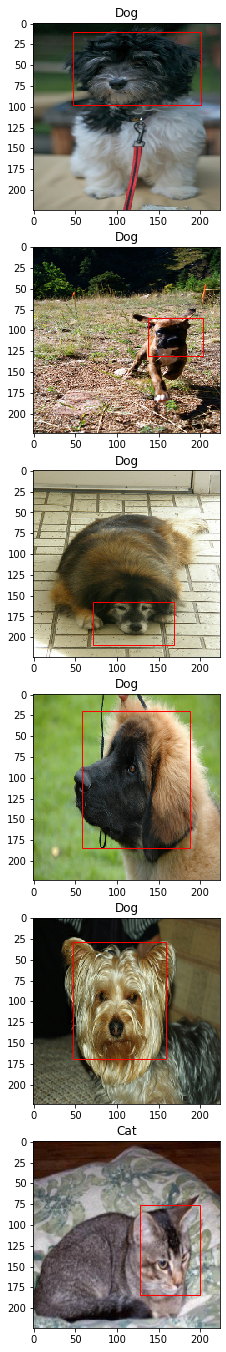

In [35]:
model.save("detect_v1.h5")
new_model = tf.keras.models.load_model("detect_v1.h5")
plt.figure(figsize=(8,24))
for img,_ in test_ds.skip(8).take(1):
    out1,out2,out3,out4,out5 = new_model.predict(img)
    for i in range(6):
        plt.subplot(6,1,i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin,ymin,xmax,ymax = out1[i]*224,out2[i]*224,out3[i]*224,out4[i]*224
        #给定左下角坐标
        rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color = "red")
        ax = plt.gca()
        ax.axes.add_patch(rect)
        
        plt.title((class_label[round(float(out5[i]))]).title())
       #plt.show()